In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [38]:
data = pd.read_excel('proj.xls')
#data= data[:100] #при иеархической кластеризации 
data.shape

(500, 68)

In [39]:
article = list(data['Article Title'])
abstracts = list(data['Abstract'])
abstracts

['Deep learning allows computational models that are composed of multiple processing layers to learn representations of data with multiple levels of abstraction. These methods have dramatically improved the state-of-the-art in speech recognition, visual object recognition, object detection and many other domains such as drug discovery and genomics. Deep learning discovers intricate structure in large data sets by using the backpropagation algorithm to indicate how a machine should change its internal parameters that are used to compute the representation in each layer from the representation in the previous layer. Deep convolutional nets have brought about breakthroughs in processing images, video, speech and audio, whereas recurrent nets have shone light on sequential data such as text and speech.',
 'We trained a large, deep convolutional neural network to classify the 1.2 million high-resolution images in the ImageNet LSVRC-2010 contest into the 1000 different classes. On the test d

Введем стоп-слова 


In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Danila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stopwords = nltk.corpus.stopwords.words('english')


In [42]:
stopwords.extend(['use', 'elsevi', 'c', 'c elsevi', 'neuron', 'research', 'deep'])
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [43]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [44]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    '''
    Разбиваем наш текст на предложения 'sent' (токинизируем)
    Уже разбитые предложения разбиваем на слова(токены) 
    '''
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    # избавляемся от знаков препинания и слов без букв
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


https://python-school.ru/nlp-text-preprocessing/
Объяснение токинизации и стеминга 


https://tproger.ru/translations/regular-expression-python/
Немного про модуль re

In [45]:
abstracts = list(map(str, abstracts))

In [46]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in abstracts:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [47]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame[vocab_frame['words']=='s']


,words
s,s
s,s


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_df=0.2, max_features=2000000,
                                 min_df=0.1, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

print(tfidf_matrix.shape)

D:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 8.19 s
(500, 121)


In [49]:
terms = tfidf_vectorizer.get_feature_names()
'''deleteterms = ['c elsevi', 'c elsevi b.v.', 'elsevi', 'elsevi b.v.', 'elsevi b.v. right']
for i in deleteterms:
    terms.pop(str(i))
    '''
terms

["'s",
 'accur',
 'accuraci',
 'across',
 'adapt',
 'addit',
 'advanc',
 'analysi',
 'appli',
 'architectur',
 'area',
 'artifici',
 'avail',
 'behavior',
 'better',
 'challeng',
 'class',
 'classif',
 'classifi',
 'cognit',
 'combin',
 'common',
 'complex',
 'condit',
 'connect',
 'consist',
 'control',
 'convolut',
 'convolut neural',
 'convolut neural network',
 'current',
 'design',
 'detect',
 'direct',
 'discuss',
 'dynam',
 'effici',
 'evalu',
 'exist',
 'experi',
 'field',
 'final',
 'find',
 'first',
 'focus',
 'follow',
 'futur',
 'general',
 'generat',
 'high',
 'human',
 'identifi',
 'implement',
 'import',
 'improv',
 'increas',
 'indic',
 'inform',
 'input',
 'integr',
 'investig',
 'involv',
 'larg',
 'level',
 'limit',
 'ltd.',
 'ltd. right',
 'ltd. right reserv',
 'machin',
 'machin learn',
 'main',
 'mani',
 'map',
 'may',
 'measur',
 'mechan',
 'multipl',
 'need',
 'new',
 'novel',
 'number',
 'object',
 'observ',
 'obtain',
 'one',
 'onli',
 'optim',
 'particular',


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1- cosine_similarity(tfidf_matrix)
print(dist)
dist.shape

[[ 0.00000000e+00  8.34494643e-01  7.27642701e-01 ...  9.16670784e-01
   9.83840777e-01  9.18668873e-01]
 [ 8.34494643e-01  0.00000000e+00  7.22052487e-01 ...  8.94800173e-01
   9.74170165e-01  9.42600903e-01]
 [ 7.27642701e-01  7.22052487e-01 -2.22044605e-16 ...  6.91612021e-01
   8.27918879e-01  6.71831275e-01]
 ...
 [ 9.16670784e-01  8.94800173e-01  6.91612021e-01 ... -2.22044605e-16
   9.39720967e-01  9.33896130e-01]
 [ 9.83840777e-01  9.74170165e-01  8.27918879e-01 ...  9.39720967e-01
   0.00000000e+00  5.47955586e-01]
 [ 9.18668873e-01  9.42600903e-01  6.71831275e-01 ...  9.33896130e-01
   5.47955586e-01 -2.22044605e-16]]


(500, 500)

In [51]:

'''Метод LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
new = lsa.fit_transform(tfidf_matrix)
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(new)

clusters = km.labels_.tolist()
'''

'Метод LSA\n\nfrom sklearn.decomposition import TruncatedSVD\nfrom sklearn.preprocessing import Normalizer\nfrom sklearn.pipeline import make_pipeline\nsvd = TruncatedSVD(100)\nnormalizer = Normalizer(copy=False)\nlsa = make_pipeline(svd, normalizer)\nnew = lsa.fit_transform(tfidf_matrix)\nfrom sklearn.cluster import KMeans\n\nnum_clusters = 5\nkm = KMeans(n_clusters=num_clusters)\n\n%time km.fit(new)\n\nclusters = km.labels_.tolist()\n'

К-means кластеризация:

In [52]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 452 ms


In [53]:
data2 = pd.read_excel('proj.xls')
#data2=data[:100] #при иеархической кластеризации
genres = list(data2['Research Areas'])
article = list(data2['Article Title'])
authors = list(data['Authors'])
ranks = []
for i in range(0,len(article)):
    ranks.append(i)

In [54]:

documents = { 'authors': authors, 'rank': ranks, 'abstracts': abstracts, 'cluster': clusters, 'genre': genres , 'article': article}

frame = pd.DataFrame(documents, index = [clusters] , columns = ['rank', 'authors', 'cluster', 'genre', 'abstracts'])
frame[frame['cluster']==0]

,rank,authors,cluster,genre,abstracts
0,26,"Song, XW; Dong, ZY; Long, XY; Li, SF; Zuo, XN;...",0,Science & Technology - Other Topics,Resting-state fMRI (RS-fMRI) has been drawing ...
0,30,"Hutchison, RM; Womelsdorf, T; Allen, EA; Bande...",0,"Neurosciences & Neurology; Radiology, Nuclear ...","The brain must dynamically integrate, coordina..."
0,34,"Holzel, BK; Lazar, SW; Gard, T; Schuman-Olivie...",0,Psychology,"Cultivation of mindfulness, the nonjudgmental ..."
0,35,"Allen, EA; Damaraju, E; Plis, SM; Erhardt, EB;...",0,Neurosciences & Neurology,Spontaneous fluctuations are a hallmark of rec...
0,43,"Lamm, C; Decety, J; Singer, T",0,"Neurosciences & Neurology; Radiology, Nuclear ...",A growing body of evidence suggests that empat...
...,...,...,...,...,...
0,472,"Bzdok, D; Schilbach, L; Vogeley, K; Schneider,...",0,Anatomy & Morphology; Neurosciences & Neurology,Morally judicious behavior forms the fabric of...
0,477,"Langner, R; Eickhoff, SB",0,Psychology,Maintaining attention for more than a few seco...
0,481,"Hardwick, RM; Rottschy, C; Miall, RC; Eickhoff...",0,"Neurosciences & Neurology; Radiology, Nuclear ...",Neuroimaging studies have improved our underst...
0,483,"Snell-Rood, EC",0,Behavioral Sciences; Zoology,I outline how understanding the mechanism of b...


Столбец 'genre' явно нужно токенизировать

In [55]:
frame['cluster'].value_counts()

2    175
0    126
1     86
3     72
4     41
Name: cluster, dtype: int64

In [56]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" %i, end='')
    for ind in order_centroids[i, :6]:
        print(vocab_frame.loc[terms[ind].split()].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for article in frame.loc[i]['authors'].values.tolist():
        print(article, end='\\')
    print()
    print()

Top terms per cluster:

Cluster 0 words:b'regions',b'connected',b'cognition',b'humans',b'involved',b'behavior',

Cluster 0 titles:Song, XW; Dong, ZY; Long, XY; Li, SF; Zuo, XN; Zhu, CZ; He, Y; Yan, CG; Zang, YF\Hutchison, RM; Womelsdorf, T; Allen, EA; Bandettini, PA; Calhoun, VD; Corbetta, M; Penna, S; Duyn, JH; Glover, GH; Gonzalez-Castillo, J; Handwerker, DA; Keilholz, S; Kiviniemi, V; Leopold, DA; Pasquale, F; Sporns, O; Walter, M; Chang, C\Holzel, BK; Lazar, SW; Gard, T; Schuman-Olivier, Z; Vago, DR; Ott, U\Allen, EA; Damaraju, E; Plis, SM; Erhardt, EB; Eichele, T; Calhoun, VD\Lamm, C; Decety, J; Singer, T\Oh, SW; Harris, JA; Ng, L; Winslow, B; Cain, N; Mihalas, S; Wang, QX; Lau, C; Kuan, L; Henry, AM; Mortrud, MT; Ouellette, B; Nguyen, TN; Sorensen, SA; Slaughterbeck, CR; Wakeman, W; Li, Y; Feng, D; Ho, A; Nicholas, E; Hirokawa, KE; Bohn, P; Joines, KM; Peng, HC; Hawrylycz, MJ; Phillips, JW; Hohmann, JG; Wohnoutka, P; Koch, C; Bernard, A; Dang, C; Jones, AR; Zeng, HK; Gerfen, CR\T

Cluster 3 titles:Srivastava, N; Hinton, G; Krizhevsky, A; Sutskever, I; Salakhutdinov, R\Schmidhuber, J\Silver, D; Schrittwieser, J; Simonyan, K; Antonoglou, I; Huang, A; Guez, A; Hubert, T; Baker, L; Lai, M; Bolton, A; Chen, YT; Lillicrap, T; Hui, F; Sifre, L; van den Driessche, G; Graepel, T; Hassabis, D\Mountrakis, G; Im, J; Ogole, C\Jordan, MI; Mitchell, TM\Lv, YS; Duan, YJ; Kang, WW; Li, ZX; Wang, FY\Cruz, CD\Zhao, HX; Magoules, F\Lin, YC; Chen, XM\Armenteros, JJA; Tsirigos, KD; Sonderby, CK; Petersen, TN; Winther, O; Brunak, S; von Heijne, G; Nielsen, H\Kourou, K; Exarchos, TP; Exarchos, KP; Karamouzis, MV; Fotiadis, DI\Butler, KT; Davies, DW; Cartwright, H; Isayev, O; Walsh, A\Karaboga, D; Ozturk, C\Bollen, J; Mao, HN; Zeng, XJ\Schurz, M; Radua, J; Aichhorn, M; Richlan, F; Perner, J\Ma, XL; Tao, ZM; Wang, YH; Yu, HY; Wang, YP\Suganthi, L; Samuel, AA\Carleo, G; Troyer, M\Huang, GB\Shen, Y; Bax, A\Zhao, R; Yan, RQ; Chen, ZH; Mao, KZ; Wang, P; Gao, RX\Angermueller, C; Parnamaa, T; 

In [57]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [58]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns


In [59]:
#set up colors per clusters using a dict
cluster_colors = {0: '#000080', 1: '#008000', 2: '#ffff00', 3: '#7570b3', 4: '#d95f02', 5: '#ff00ff', 6: '#000000', 7:'#657228', 8:'#228228'}

#set up cluster names using a dict
cluster_names = {0: 'connected cognition humans behavior', 
                 1: 'control adaptive design signals inputs', 
                 2: 'time increasing optimize', 
                 3: 'machine predictions recognition challenging artificial', 
                 4: 'classification convolutional detection classify',
                 5: '',
                 6:'',
                 7: '',
                 8: '',
                 9: ''}

In [60]:
%matplotlib inline


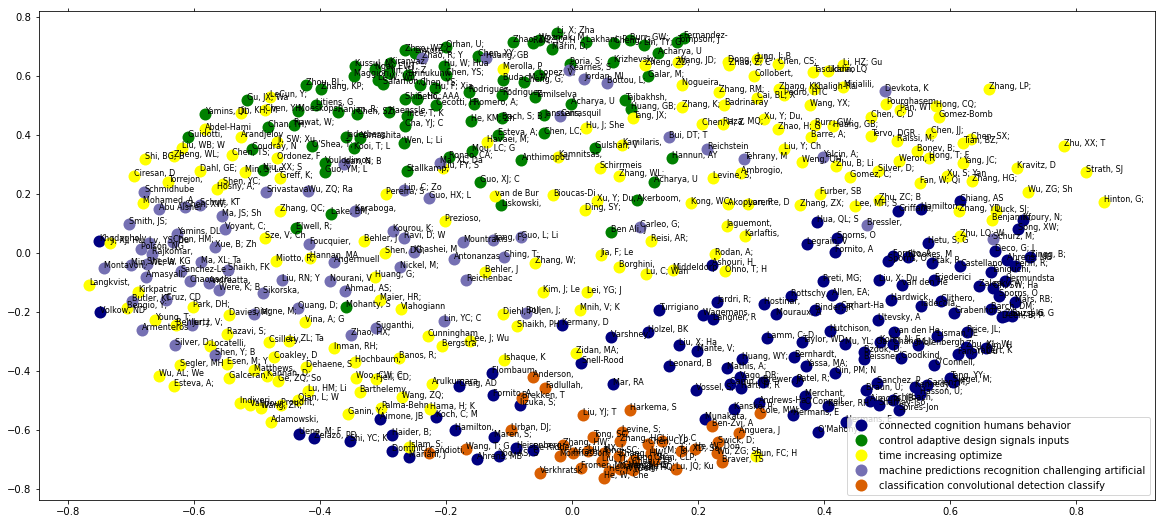

In [61]:
### create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, author=authors)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['author'][:10], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

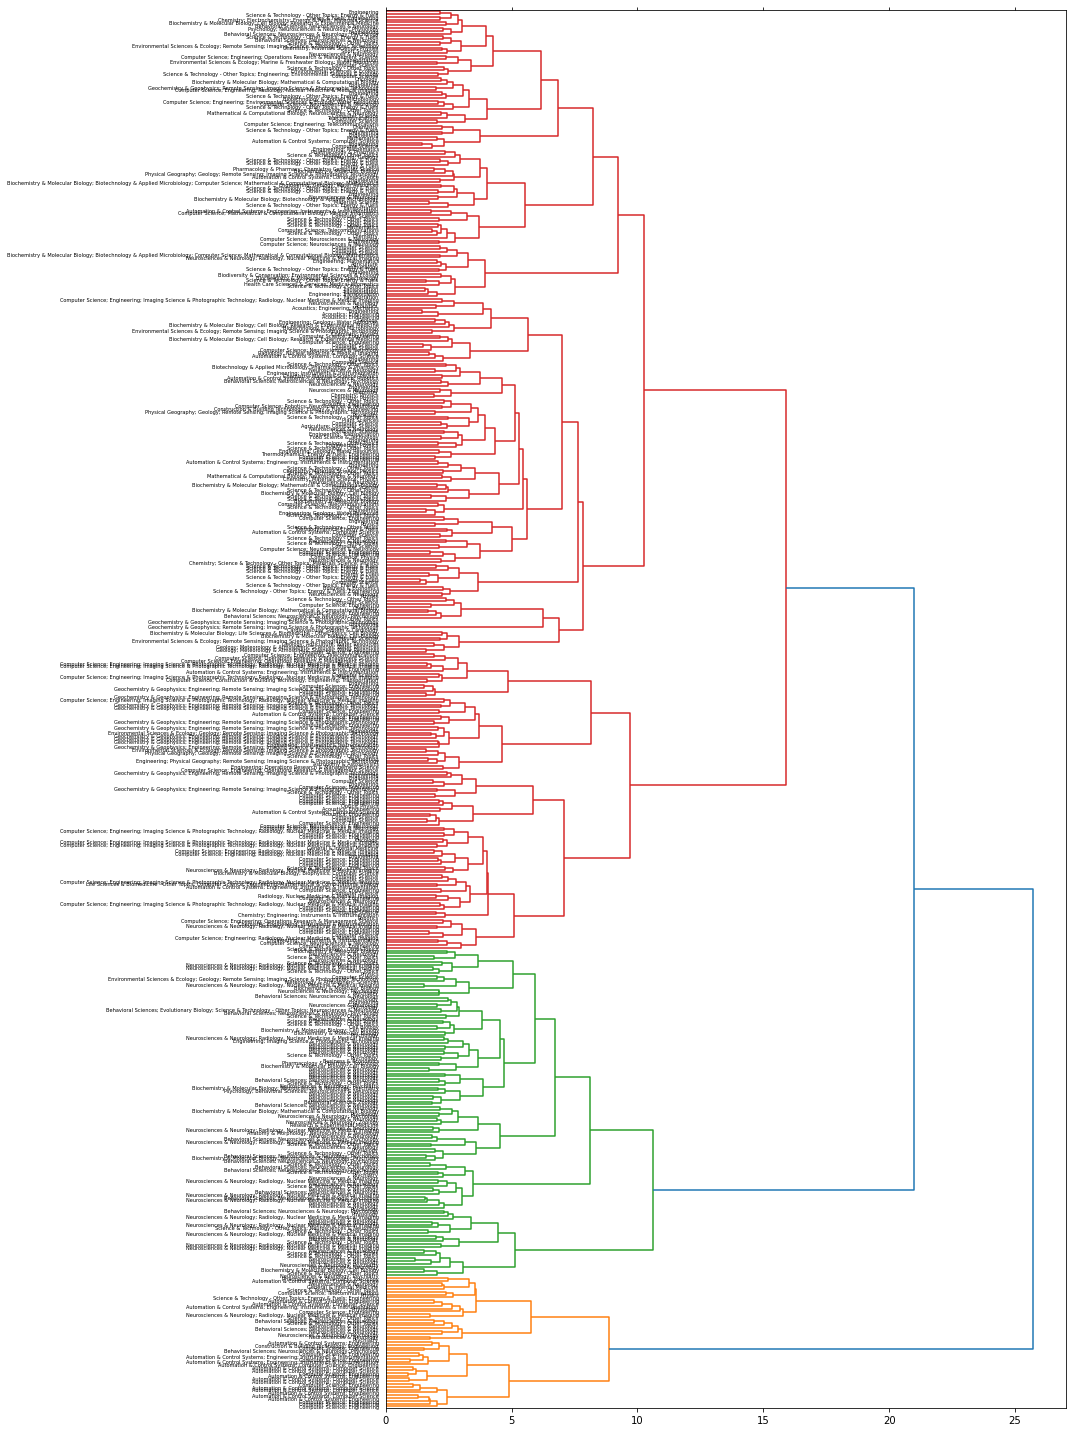

In [26]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels= genres);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('C:\\Users\\Danila\\Desktop\\учеба\\Проект\\ward.pdf', dpi=200) #save figure as ward_clusters

In [27]:
#чтобы проследить авторов кластеров

'''label = fcluster(linkage_matrix, 2.2, criterion='distance')
np.unique(label)'''

for i, group in df.groupby('label'):
    print('-'*10)
    print('cluster {}'.format(i))
    print (group)

----------
cluster 0
            x         y  label  \
2   -0.485734  0.207179      0   
3   -0.679230  0.206469      0   
4    0.012185 -0.193953      0   
5    0.843440  0.174046      0   
6    0.485162  0.279332      0   
..        ...       ...    ...   
494 -0.601506 -0.183195      0   
495  0.430252  0.562444      0   
496  0.325597  0.642276      0   
497  0.226837 -0.004738      0   
498  0.335627  0.537799      0   

                                                author  
2    Srivastava, N; Hinton, G; Krizhevsky, A; Sutsk...  
3                                       Schmidhuber, J  
4    Mnih, V; Kavukcuoglu, K; Silver, D; Rusu, AA; ...  
5    Hinton, G; Deng, L; Yu, D; Dahl, GE; Mohamed, ...  
6    Silver, D; Huang, A; Maddison, CJ; Guez, A; Si...  
..                                                 ...  
494               Park, DH; Kim, HK; Choi, IY; Kim, JK  
495           Mirjalili, S; Hashim, SZM; Sardroudi, HM  
496                Chen, CS; Duan, SX; Cai, T; Liu, BY  


In [28]:
data[data['Authors']=='Braver, TS']['Article Title']

44    The variable nature of cognitive control: a du...
Name: Article Title, dtype: object

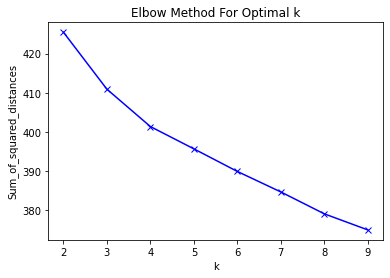

In [29]:
Sum_of_squared_distances = []
K = range(2,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [30]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(tfidf_matrix)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(authors,labels)),columns=['authors','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                                               authors  cluster
249                             Bressler, SL; Seth, AK        0
208        Lei, YG; Jia, F; Lin, J; Xing, SB; Ding, SX        0
210                       Ji, XJ; Huang, H; Ouyang, PK        0
412                     Wu, ZG; Shi, P; Su, HY; Chu, J        0
411  Lorente, D; Aleixos, N; Gomez-Sanchis, J; Cube...        0
..                                                 ...      ...
240   Kussul, N; Lavreniuk, M; Skakun, S; Shelestov, A        3
242  Acharya, UR; Oh, SL; Hagiwara, Y; Tan, JH; Ade...        3
245  Sirinukunwattana, K; Raza, SEA; Tsang, YW; Sne...        3
180  Anthimopoulos, M; Christodoulidis, S; Ebner, L...        3
0                       LeCun, Y; Bengio, Y; Hinton, G        3

[500 rows x 2 columns]


In [31]:
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [32]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in abstracts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

D:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Wall time: 1.93 s
Wall time: 3.79 s
Wall time: 333 ms


In [33]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 1min 52s


In [34]:
lda.show_topics()

[(0,
  '0.018*"model" + 0.016*"featur" + 0.016*"propos" + 0.015*"method" + 0.011*"network" + 0.010*"forecast" + 0.009*"perform" + 0.009*"classif" + 0.009*"energi" + 0.008*"system"'),
 (1,
  '0.011*"network" + 0.010*"neural" + 0.008*"train" + 0.007*"devic" + 0.007*"synaps" + 0.006*"molecul" + 0.005*"denois" + 0.005*"artifici" + 0.005*"circuit" + 0.005*"system"'),
 (2,
  '0.020*"learn" + 0.015*"data" + 0.013*"imag" + 0.013*"model" + 0.012*"network" + 0.011*"method" + 0.008*"algorithm" + 0.008*"applic" + 0.007*"neural" + 0.007*"comput"'),
 (3,
  '0.026*"control" + 0.019*"system" + 0.015*"network" + 0.011*"neural" + 0.010*"propos" + 0.010*"design" + 0.009*"adapt" + 0.008*"state" + 0.008*"effect" + 0.007*"nonlinear"'),
 (4,
  '0.018*"network" + 0.017*"brain" + 0.014*"function" + 0.013*"activ" + 0.009*"region" + 0.009*"connect" + 0.008*"neural" + 0.008*"process" + 0.008*"studi" + 0.007*"cortex"')]

In [35]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('model', 0.017708091)", "('featur', 0.01603796)", "('propos', 0.015580437)", "('method', 0.014745889)", "('network', 0.010760752)", "('forecast', 0.010326334)", "('perform', 0.008988762)", "('classif', 0.008899871)", "('energi', 0.008728324)", "('system', 0.008204239)", "('neural', 0.0077459747)", "('result', 0.0076453863)", "('paper', 0.006467191)", "('power', 0.00639712)", "('detect', 0.006223086)", "('learn', 0.0061504073)", "('data', 0.006111888)", "('accuraci', 0.005947016)", "('train', 0.0057986896)", "('base', 0.0057792156)"]

["('network', 0.010888693)", "('neural', 0.010166871)", "('train', 0.008442653)", "('devic', 0.007432981)", "('synaps', 0.0072783567)", "('molecul', 0.0060706115)", "('denois', 0.005296221)", "('artifici', 0.005082082)", "('circuit', 0.004954014)", "('system', 0.004858957)", "('structur', 0.0047205496)", "('stimul', 0.004643327)", "('synapt', 0.0045373505)", "('neuromorph', 0.003983931)", "('memori', 0.003968146)", "('potenti', 0.0039099166)", "('memris

<ipython-input-35-37f9c4e5b9d9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics_matrix = np.array(topics_matrix)


In [36]:
topics_matrix

array([[0,
        list([('model', 0.017708091), ('featur', 0.01603796), ('propos', 0.015580437), ('method', 0.014745889), ('network', 0.010760752), ('forecast', 0.010326334), ('perform', 0.008988762), ('classif', 0.008899871), ('energi', 0.008728324), ('system', 0.008204239), ('neural', 0.0077459747), ('result', 0.0076453863), ('paper', 0.006467191), ('power', 0.00639712), ('detect', 0.006223086), ('learn', 0.0061504073), ('data', 0.006111888), ('accuraci', 0.005947016), ('train', 0.0057986896), ('base', 0.0057792156)])],
       [1,
        list([('network', 0.010888693), ('neural', 0.010166871), ('train', 0.008442653), ('devic', 0.007432981), ('synaps', 0.0072783567), ('molecul', 0.0060706115), ('denois', 0.005296221), ('artifici', 0.005082082), ('circuit', 0.004954014), ('system', 0.004858957), ('structur', 0.0047205496), ('stimul', 0.004643327), ('synapt', 0.0045373505), ('neuromorph', 0.003983931), ('memori', 0.003968146), ('potenti', 0.0039099166), ('memristor', 0.0037221038), ('